In [1]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


In [2]:
labels = pd.read_csv("stage_2_train_labels.csv")

In [3]:
labels.head(6)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1


In [4]:
labels = labels.drop_duplicates("patientId")

In [5]:
ROOT_PATH = Path("stage_2_train_images/")
SAVE_PATH = Path("Processed")

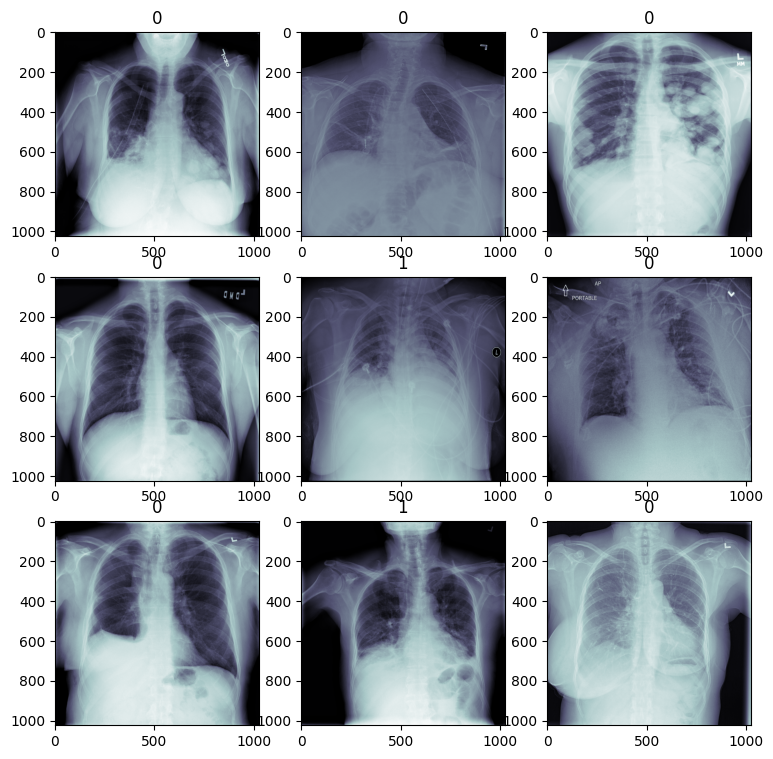

In [6]:
fig, axis = plt.subplots(3, 3, figsize=(9,9))
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.dcmread(dcm_path).pixel_array
        
        label = labels["Target"].iloc[c]

        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        c+=1

In [7]:
sums, sums_squared = 0, 0 

for c, patient_id in enumerate(tqdm(labels.patientId)):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.dcmread(dcm_path).pixel_array / 255

        dcm_array = cv2.resize(dcm, (224, 224)).astype(np.float16)

        label = labels.Target.iloc[c]

        train_or_val = "train" if c < 24000 else "val"
    
        current_save_path = SAVE_PATH/train_or_val/str(label)
        current_save_path.mkdir(parents=True, exist_ok=True)

        np.save(current_save_path/patient_id, dcm_array)

        normalizer = 224*224
        if train_or_val == "train":
                sums += np.sum(dcm_array) / normalizer
                sums_squared += (dcm_array ** 2).sum() / normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [9]:
mean = sums / 24000
std = np.sqrt((sums_squared / 24000) - mean**2)

In [10]:
mean, std

(np.float16(0.0853), np.float16(0.234))